In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo

In [12]:
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
epoch = 135
pre_epoch = 0
batch_size = 128
lr = 0.01

In [54]:
transform_train = transfrms.Compose([
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [55]:
trainset = torchvision.datasets.CIFAR10(root='data',train=True,download=True,transform=transform_train)




Files already downloaded and verified


In [56]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)




In [78]:
testset = torchvision.datasets.CIFAR10(root='data',train=False,download=True,transform=transform_test)

testloader = torch.utils.data.DataLoader(testset,batch_size=10,shuffle=False)


Files already downloaded and verified


In [70]:
net = ResNet(ResidualBlock)

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9,weight_decay=5e-4)

In [35]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision

class ResidualBlock(nn.Module):
    """
    子 module: Residual Block ---- ResNet 中一个跨层直连的单元
    """
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        # 如果输入和输出的通道不一致，或其步长不为 1，需要将二者转成一致
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)  # 输出 + 输入
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    """
    实现主 module: ResNet-18
    ResNet 包含多个 layer, 每个 layer 又包含多个 residual block (上面实现的类)
    因此, 用 ResidualBlock 实现 Residual 部分，用 _make_layer 函数实现 layer
    """
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        # 最开始的操作
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        # 四个 layer， 对应 2， 3， 4， 5 层， 每层有两个 residual block
        self.layer1 = self._make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self._make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(ResidualBlock, 512, 2, stride=2)
        # 最后的全连接，分类时使用
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, channels, num_blocks, stride):
        """
        构建 layer, 每一个 layer 由多个 residual block 组成
        在 ResNet 中，每一个 layer 中只有两个 residual block
        """
        layers = []
        for i in range(num_blocks):
            if i == 0:  # 第一个是输入的 stride
                layers.append(block(self.inchannel, channels, stride))
            else:    # 后面的所有 stride，都置为 1
                layers.append(block(channels, channels, 1))
            self.inchannel = channels
        return nn.Sequential(*layers)  # 时序容器。Modules 会以他们传入的顺序被添加到容器中。

    def forward(self, x):
        # 最开始的处理
        out = self.conv1(x)
        # 四层 layer
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # 全连接 输出分类信息
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


def Accuracy(testloader, net, device):
    # 使用测试数据测试网络
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # 将输入和目标在每一步都送入GPU
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    return 100.0 * correct / total


def run(device):
    # 超参数设置
    # 批处理尺寸(batch_size)
    BATCH_SIZE = 128
    # 学习率
    LR = 0.1
    # 加载数据集
    # 标准化为范围在[-1, 1]之间的张量
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # 训练集
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)  # 训练数据集
    # 生成一个个batch进行批训练，组成batch的时候顺序打乱取
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
    # 测试集
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)
    # Cifar-10的标签
    # 建立神经网络
    net = ResNet(ResidualBlock).to(device)
    # 定义损失函数
    criterion = nn.CrossEntropyLoss()  # 损失函数为交叉熵，多用于多分类问题
    # 优化方式为mini-batch momentum-SGD，并采用L2正则化（权重衰减）
    optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
    # 训练网络
    # loop over the dataset multiple times
    for epoch in range(5):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # 取数据
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
            # 将梯度置零
            optimizer.zero_grad()
            # 训练
            outputs = net(inputs)
            loss = criterion(outputs, labels).to(device)
            loss.backward()  # 反向传播
            optimizer.step()  # 优化
            # 统计数据
            running_loss += loss.item()
            if i >= 0:  # 每 2000 张图片，打印一次
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
                acc = Accuracy(testloader, net, device)
                
                
                
                

In [4]:
net = torch.load('/Users/liuchu/Downloads/net1 (1).pth',map_location=torch.device('cpu'))

In [14]:
transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

RuntimeError: Dataset not found or corrupted. You can use download=True to download it

In [14]:
Accuracy(testloader,net,'cpu')        

Accuracy of the network on the 10000 test images: 84 %


84.36

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(),(1,2,0)))
    plt.show()

for i,(images,_) in enumerate(testloader):
    print(i)
    print(images.numpy().shape)
    v = torchvision.utils.make_grid(images)
    print(type(v))
    imshow(v)
    break

NameError: name 'testloader' is not defined

In [9]:
path = '/Users/liuchu/Desktop/clean/clean/0.png'

In [3]:
import os

In [4]:
for file_name in os.listdir(path):
    print(file_name)

label.txt
clean


In [5]:
!du -d=1 -h /Users/liuchu/Desktop/clean

235M	/Users/liuchu/Desktop/clean


In [17]:
from PIL import Image
import numpy as np

img_PIL = Image.open(path)#读取数据

print("img_PIL:",img_PIL)

print("img_PIL:",type(img_PIL))

#将图片转换成np.ndarray格式
img_PIL = np.array(img_PIL)
print("img_PIL:",img_PIL.shape)

print("img_PIL:",type(img_PIL))


img_PIL: <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x123D56470>
img_PIL: <class 'PIL.PngImagePlugin.PngImageFile'>
img_PIL: (32, 32, 3)
img_PIL: <class 'numpy.ndarray'>


TypeError: Invalid dimensions for image data

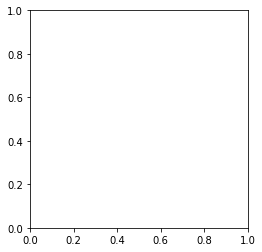

In [21]:
imshow1(img_PIL)

In [20]:
def imshow1(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img,(1,2,0)))
    plt.show()

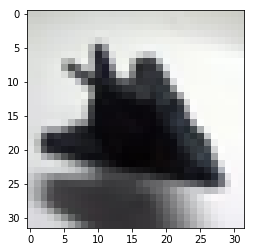

In [22]:
img_PIL = Image.open(path)
plt.imshow(img_PIL)
plt.show()

In [100]:
import os
import torch
from torch.utils import data
from PIL import Image
import numpy as np
from torchvision import transforms

transform = transforms.Compose([
 transforms.ToTensor(), # 将图片转换为Tensor,归一化至[0,1]
 transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5]) # 标准化至[-1,1]
])

#定义自己的数据集合
class FlameSet(data.Dataset):
    def __init__(self,root):
      # 所有图片的绝对路径
        last_dir = os.path.abspath(os.path.join(root,'..'))
        label_path = os.path.join(last_dir,'label.txt')
        self.mapping = {}
        if os.path.exists(label_path):
            with open(label_path,'r') as f:
                for s in f.readlines():
                    s = s.strip()
                    v1,v2 = s.split(' ')
                    v2 = int(v2)
                    self.mapping[v1] = v2
        imgs=os.listdir(root)
        self.imgs=[os.path.join(root,k) for k in imgs]
        self.transforms=transform

    def __getitem__(self, index):
        img_path = self.imgs[index]
        name = os.path.basename(img_path)
        pil_img = Image.open(img_path)
        if self.transforms:
            data = self.transforms(pil_img)
        else:
            pil_img = np.asarray(pil_img)
            data = torch.from_numpy(pil_img)
        if self.mapping:
            return data,torch.tensor(self.mapping[name])
        else:
            return data,name
    
    
    def __len__(self):
        return len(self.imgs)
    
    


In [53]:
print(os.path.abspath(os.path.dirname('/Users/liuchu/Desktop/../')))

/Users/liuchu


In [84]:
plt.figure(figsize=(1,1))

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(),(1,2,0)))
    plt.show()

dataSet=FlameSet('/Users/liuchu/Desktop/clean/clean')
dataloader = torch.utils.data.DataLoader(dataSet, batch_size=64, shuffle=False)

for i,images in enumerate(dataloader):
    print(i)
    print(images.numpy().shape)
    v = torchvision.utils.make_grid(images)
    print(type(v))
    imshow(v)
    break
# v = torchvision.utils.make_grid(dataSet[100])
# imshow(v)

0


AttributeError: 'list' object has no attribute 'numpy'

<Figure size 72x72 with 0 Axes>

In [38]:
net = torch.load('net1 (1).pth',map_location=torch.device('cpu'))
outputs = net(dataSet[0])
_, predicted = torch.max(outputs.data, 1)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 3, 3], but got 3-dimensional input of size [3, 32, 32] instead

In [71]:
device = 'cpu'
with torch.no_grad():
    for data in dataloader:
        images,label = data
        # 将输入和目标在每一步都送入GPU
        images = images.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        print((label == predicted).sum().item())
        break

tensor([3, 0, 8, 6, 9, 5, 4, 8, 4, 2, 4, 6, 2, 3, 4, 6, 3, 7, 5, 4, 1, 5, 2, 5,
        1, 3, 0, 0, 8, 2, 2, 4, 5, 0, 3, 6, 6, 3, 4, 4, 5, 1, 7, 5, 3, 9, 2, 6,
        7, 5, 1, 4, 5, 6, 7, 0, 1, 9, 3, 5, 6, 5, 1, 4])
60


In [72]:
Accuracy(dataloader,net,'cpu')

Accuracy of the network on the 10000 test images: 94 %


94.32

In [75]:
B_data_set = FlameSet('/Users/liuchu/Desktop/B')
B_loader = torch.utils.data.DataLoader(B_data_set, batch_size=64, shuffle=False)

In [101]:
A_data_set = FlameSet('/Users/liuchu/Desktop/A')
A_loader = torch.utils.data.DataLoader(A_data_set, batch_size=64, shuffle=False)

In [95]:
arr = ['飞机', '汽车' ,'鸟', '猫','鹿','狗', '青蛙', '马','船','卡车']

In [87]:


def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(),(1,2,0)))
    plt.show()

In [88]:
from collections import defaultdict

In [109]:
result = []
for i,alist in enumerate(A_loader):
#     print(alist)
    images,names = alist
    
#     print(i)
#     print(images.numpy().shape)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    print(predicted)
#     v = torchvision.utils.make_grid(images)
#     print(type(v))
#     imshow(v)
    hh = defaultdict(list)
    for img,pre,name in zip(images,predicted,names):
#         imshow(img)
        label = arr[pre.item()]
        hh[label].append([img,name]) 
        result.append([name,pre.item()])
#     print(hh)
#     for k in hh:
#         imlist = [v[0] for v in hh[k]]
#         namelist = [v[1] for v in hh[k]]
#         imshow(torchvision.utils.make_grid(imlist))
#         print(k,namelist)
#     if i > 5:
#         break

tensor([3, 0, 7, 5, 6, 6, 5, 6, 8, 2, 3, 4, 4, 0, 8, 1, 6, 5, 0, 8, 0, 3, 3, 1,
        8, 5, 5, 8, 1, 5, 5, 0, 1, 8, 5, 4, 4, 6, 1, 7, 8, 9, 1, 7, 1, 2, 9, 0,
        5, 6, 9, 5, 5, 9, 3, 6, 0, 7, 2, 6, 7, 1, 1, 6])
tensor([7, 3, 0, 7, 2, 8, 1, 4, 3, 7, 9, 4, 7, 7, 3, 0, 7, 9, 8, 1, 6, 0, 9, 2,
        8, 4, 6, 7, 6, 8, 8, 9, 2, 5, 8, 0, 3, 5, 1, 2, 2, 5, 5, 1, 4, 7, 3, 2,
        9, 9, 4, 5, 7, 7, 0, 1, 6, 6, 5, 5, 3, 2, 2, 5])
tensor([4, 3, 9, 2, 2, 5, 3, 5, 7, 9, 2, 9, 6, 3, 0, 5, 0, 4, 1, 4, 4, 4, 9, 4,
        8, 1, 9, 7, 8, 4, 5, 2, 4, 3, 9, 4, 6, 8, 6, 0, 3, 4, 3, 7, 1, 1, 5, 4,
        0, 8, 1, 0, 8, 9, 6, 3, 5, 0, 7, 8, 7, 3, 8, 6])
tensor([6, 5, 7, 2, 3, 9, 6, 1, 6, 8, 3, 2, 1, 9, 8, 4, 7, 0, 8, 4, 7, 4, 4, 9,
        3, 5, 5, 7, 0, 9, 8, 3, 0, 7, 0, 5, 6, 4, 0, 6, 8, 2, 9, 5, 5, 3, 8, 6,
        7, 5, 4, 6, 5, 4, 2, 1, 1, 8, 2, 9, 8, 3, 6, 0])
tensor([0, 5, 3, 6, 3, 5, 1, 7, 0, 1, 2, 4, 9, 5, 7, 4, 4, 1, 0, 2, 8, 7, 9, 6,
        9, 5, 3, 9, 6, 1, 8, 8, 6, 0, 2, 1, 5, 9, 4,

In [111]:
text = []
for name,pre in result:
#     print(name,pre)
    text.append('{} {}'.format(name,str(pre)))

In [112]:
with open('/Users/liuchu/Desktop/result.txt','w') as f:
    f.write('\n'.join(text))

In [114]:
for dir_name,file_name in [('A','A.txt'),('B','B.txt'),('clean/clean','clean.txt')]:
    A_data_set = FlameSet('/Users/liuchu/Desktop/{}'.format(dir_name))
    A_loader = torch.utils.data.DataLoader(A_data_set, batch_size=64, shuffle=False)

    result = []
    for i,alist in enumerate(A_loader):
    #     print(alist)
        images,names = alist

    #     print(i)
    #     print(images.numpy().shape)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
#         print(predicted)
    #     v = torchvision.utils.make_grid(images)
    #     print(type(v))
    #     imshow(v)
        hh = defaultdict(list)
        for img,pre,name in zip(images,predicted,names):
    #         imshow(img)
            label = arr[pre.item()]
            hh[label].append([img,name]) 
            result.append([name,pre.item()])
    #     print(hh)
    #     for k in hh:
    #         imlist = [v[0] for v in hh[k]]
    #         namelist = [v[1] for v in hh[k]]
    #         imshow(torchvision.utils.make_grid(imlist))
    #         print(k,namelist)
    #     if i > 5:
    #         break
    text = []
    for name,pre in result:
    #     print(name,pre)
        text.append('{} {}'.format(name,str(pre)))
    with open('/Users/liuchu/Desktop/{}'.format(file_name),'w') as f:
        f.write('\n'.join(text))
    print(dir_name)

A
B
clean/clean
